In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


NOTA: Esto es solo para entrenamiento en GPU del modelo en Colab, 
luego solo se descarga el checkpoint del Modelo Generado...

In [0]:
import os
os.chdir("drive/My Drive/test/")

In [0]:
!ls images/train_dataset.h5

images/train_dataset.h5


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Lastest Version
from __future__ import absolute_import, division, print_function

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import skimage.color
import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.INFO)

DATA_DIR = 'images/'


def cnn_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module(
        "https://tfhub.dev/google/imagenet/inception_v3/classification/1", trainable=True)

    input_layer = tf.reshape(features["x"], [-1, 299, 299, 3])
    
    outputs = module(dict(images=input_layer),
                     signature="image_classification",
                     as_dict=True)

    middle_output = outputs["InceptionV3/Mixed_7c"]
    
    avgPool = tf.reduce_mean(middle_output, axis=[1, 2])

    bn1 = tf.layers.batch_normalization(
        avgPool, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits1 = tf.layers.dense(inputs=bn1, units=128,
                              activation=tf.nn.relu)

    dropout1 = tf.layers.dropout(
        inputs=logits1, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits2 = tf.layers.dense(inputs=dropout1, units=64,
                              activation=tf.nn.relu)

    dropout2 = tf.layers.dropout(
        inputs=logits2, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout2, units=3)



    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=3)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

        summary_hook = tf.train.SummarySaverHook(
            100,
            output_dir='/tmp/tf',
            summary_op=tf.summary.merge_all())

        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,
                                          training_hooks=[summary_hook])

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



def main(unused_argv):
    with tf.Graph().as_default() as g:
        # Load training and eval data
        ftrain = h5py.File(DATA_DIR + 'train_dataset_5_.h5', 'r')
        ftest = h5py.File(DATA_DIR + 'test_dataset_5_.h5', 'r')

        train_data, train_labels = ftrain['train_set_x'],  ftrain['train_set_y']
        eval_data, eval_labels = ftest['test_set_x'], ftest['test_set_y']
       
        train_data = np.asarray(train_data, dtype=np.float32)
        train_data = train_data/255.
        # train_data = skimage.color.rgb2gray(train_data)
        train_labels = np.asarray(
            train_labels, dtype=np.int32).reshape(train_labels.shape[0])

        eval_data = np.asarray(eval_data, dtype=np.float32)
        eval_data = eval_data/255.
        # eval_data = skimage.color.rgb2gray(eval_data)
        eval_labels = np.asarray(
            eval_labels, dtype=np.int32).reshape(eval_labels.shape[0])
        
        
        # Testing purposes...
        # plt.imshow(train_data[21])
        # plt.show()

        # Create the Estimator
        mnist_classifier = tf.estimator.Estimator(
            model_fn=cnn_model_fn,
            model_dir="tmp")

        # Train the model
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": train_data},
            y=train_labels,
            batch_size=32,
            num_epochs=50,
            shuffle=True)

        # Evaluate the model and print results
        eval_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": eval_data},
            y=eval_labels,
            num_epochs=1,
            shuffle=False)

        SAVE_EVERY_N_STEPS = 1000

        for _ in range(50):
            mnist_classifier.train(
                input_fn=train_input_fn,
                steps=1000)

            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            print(eval_results)


if __name__ == "__main__":
    tf.app.run()

INFO:tensorflow:Using config: {'_model_dir': 'tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 200, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b47dbcb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0502 20:06:49.575746 140042659829632 estimator.py:201] Using config: {'_model_dir': 'tmp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 200, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b47dbcb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


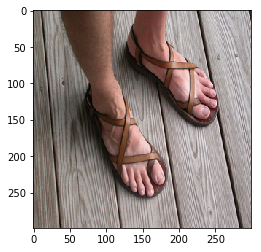

INFO:tensorflow:Calling model_fn.


I0502 20:06:50.458835 140042659829632 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0502 20:06:55.513928 140042659829632 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0502 20:06:55.920532 140042659829632 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0502 20:06:56.982837 140042659829632 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from tmp/model.ckpt-17000


I0502 20:06:56.996508 140042659829632 saver.py:1270] Restoring parameters from tmp/model.ckpt-17000


INFO:tensorflow:Running local_init_op.


I0502 20:06:58.488424 140042659829632 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0502 20:06:58.693371 140042659829632 session_manager.py:493] Done running local_init_op.


{'classes': 1, 'probabilities': array([0., 1., 0.], dtype=float32)}


In [0]:
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import skimage.color
from PIL import Image
import tensorflow_hub as hub

#from test1 import cnn_model_fn

def cnn_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module(
        "https://tfhub.dev/google/imagenet/inception_v3/classification/1")

    input_layer = tf.reshape(features["x"], [-1, 299, 299, 3])
    
    outputs = module(dict(images=input_layer),
                     signature="image_classification",
                     as_dict=True)

    # print(outputs.items())

    middle_output = outputs["InceptionV3/Mixed_7c"]

    avgPool = tf.reduce_mean(middle_output, axis=[1, 2])

    bn1 = tf.layers.batch_normalization(
        avgPool, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits1 = tf.layers.dense(inputs=bn1, units=128,
                              activation=tf.nn.relu)

    dropout1 = tf.layers.dropout(
        inputs=logits1, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits2 = tf.layers.dense(inputs=dropout1, units=64,
                              activation=tf.nn.relu)

    dropout2 = tf.layers.dropout(
        inputs=logits2, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    logits = tf.layers.dense(inputs=dropout2, units=3)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=3)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

        summary_hook = tf.train.SummarySaverHook(
            100,
            output_dir='/tmp/tf',
            summary_op=tf.summary.merge_all())

        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,
                                          training_hooks=[summary_hook])

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


DATA_DIR = 'images/'

# ftrain = h5py.File(DATA_DIR + 'train_dataset_1_.h5', 'r')
# ftest = h5py.File(DATA_DIR + 'test_dataset_1_.h5', 'r')

# train_data, train_labels =  ftrain['train_set_x'],  ftrain['train_set_y']
# eval_data, eval_labels = ftest['test_set_x'], ftest['test_set_y']

# train_data = np.asarray(train_data, dtype=np.float32)
# # train_data = train_data/255.
# # train_data = skimage.color.rgb2gray(train_data)
# train_labels = np.asarray(
#     train_labels, dtype=np.int32).reshape(train_labels.shape[0])

# eval_data = np.asarray(eval_data, dtype=np.float32)
# # eval_data = eval_data/255.
# # eval_data = skimage.color.rgb2gray(eval_data)
# eval_labels = np.asarray(
#     eval_labels, dtype=np.int32).reshape(eval_labels.shape[0])


checkpointing_config = tf.estimator.RunConfig(
    save_checkpoints_steps=500,
    keep_checkpoint_max=200
)

mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn,
    model_dir="tmp",
    config=checkpointing_config
)

# predict_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": eval_data},
#     num_epochs=1,
#     shuffle=False
# )


# out = mnist_classifier.predict(input_fn=predict_input_fn)
# predictions = [gen["classes"] for gen in out]

# accuracy = predictions - eval_labels
# pred = 1 - np.count_nonzero(accuracy) / len(eval_labels)
# print("Accuracy: ", pred)


# # ### load self made picture
img1 = Image.open(
    't_images/t_s6.jpg')
img1 = img1.resize((299, 299), Image.ANTIALIAS)
img = np.asarray(img1) / np.float(255)
img = np.asarray(img, dtype=np.float32).reshape(-1, 299, 299, 3)

# orig_image = cv2.imread(
#     'C:\\Users\\PC\\Downloads\\test_Conv\\Convolutional Models\\DatasetCreation\\t_images\\t_sneaker4.jpg', 0)
# # Test
# orig_image = orig_image/np.float(255)
# orig_image = skimage.color.rgb2gray(orig_image)
# plt.imshow(orig_image, cmap='gist_gray')
# plt.show()
# orig_image = cv2.resize(orig_image, (64, 64))
# plt.imshow(orig_image, cmap='gist_gray')
# plt.show()
# picture = np.asarray(orig_image, dtype=np.float32)


# orig_image = eval_data[86]
# # Test
plt.imshow(img1)
plt.show()
# picture = np.asarray(orig_image, dtype=np.float32)


predict_input_fn2 = tf.estimator.inputs.numpy_input_fn(
    x={"x": img},
    num_epochs=1,
    shuffle=False)


predict_results = mnist_classifier.predict(input_fn=predict_input_fn2)
# prediction = [gen["probabilities"] for gen in predict_results]
# print(prediction)
for x in predict_results:
    # cls.append(x['classes'])
    # probs.append(x['probabilities'])
    print(x)

In [0]:
!pip install tensorflow_hub